<a href="https://colab.research.google.com/github/PrajwalSingh98/Ball-Tracking/blob/main/Ball_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball Tracking

## Introduction

The objective of this assignment was to develop a computer vision program to track the movement of colored balls across various quadrants in a video. The program was tasked with detecting events of each ball entering and exiting numbered quadrants, and recording these events in a specified format: ***Time, Quadrant Number, Ball Colour, Type (Entry or Exit).*** The processed video was to display ball tracking with color-coded overlays and timestamps, while generating a text file to document the events. This task involved advanced computer vision techniques, including color detection, object tracking, and event recording, to accurately monitor the movement of balls and report the corresponding activities.

## Install Prerequisites and Video data

Download the video from the Google drive link

In [59]:
#Load video from drive where the file is uploaded
#The file ID is the string is the between d/ and /view -> https://drive.google.com/file/d/{..........}/view?usp=sharing
! gdown 19x0wawwbyDSOq9RVQlav72Bl72aOhZRH

Downloading...
From (original): https://drive.google.com/uc?id=19x0wawwbyDSOq9RVQlav72Bl72aOhZRH
From (redirected): https://drive.google.com/uc?id=19x0wawwbyDSOq9RVQlav72Bl72aOhZRH&confirm=t&uuid=008be1f8-dcbc-48c0-83de-59e3c24c2794
To: /content/AI Assignment video.mp4
100% 267M/267M [00:03<00:00, 73.8MB/s]


Install **Supervision**

In [60]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.21.0


Import Helper functions

In [61]:
import cv2
from matplotlib import pyplot as plt
import imutils
import numpy as np

In [62]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Experiment to explore data

Get video dimensions and figure coordinates to crop the image

VideoInfo(width=1920, height=1080, fps=30, total_frames=3183)
950 920


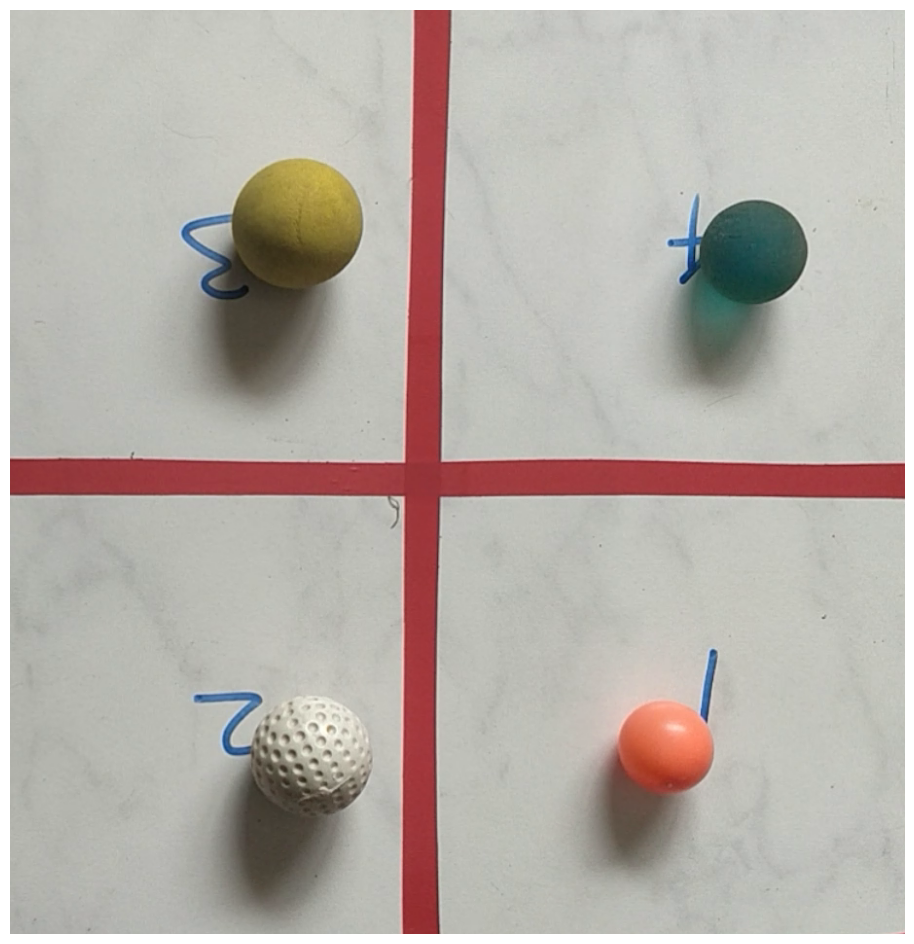

In [63]:
video_info=sv.VideoInfo.from_video_path(video_path='/content/AI Assignment video.mp4')
fps=video_info.fps
total_frames=video_info.total_frames
print(video_info)
generator = sv.get_video_frames_generator(source_path='/content/AI Assignment video.mp4', start=425)
iterator = iter(generator)
raw_frame = next(iterator)
frame=raw_frame[40:-90,810:-190]
x_offset=810
y_offset=40
height,width=frame.shape[:2]
print(height,width)
sv.plot_image(frame,(12,12))

### Minor Helper Functions

In [64]:
def color_code(i): #To return color name
  if i==0:
    return "yellow"
  elif i==1:
    return "peach"
  elif i==2:
    return "dark-green"

In [65]:
def zone(x,y)->int: #To return zone
  if x<=475 and y<=460:
    return 3
  elif x<=475 and y>460:
    return 2
  elif x>475 and y<=460:
    return 4
  else:
    return 1

### Process single frame

1


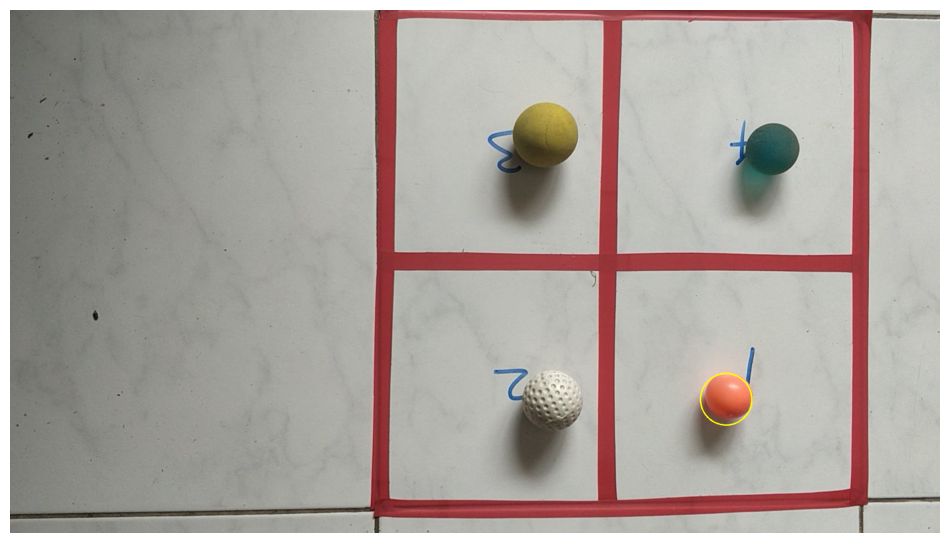

In [66]:
#preprocess frame
blurred = cv2.GaussianBlur(frame, (11, 11), 0)
hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

#create mask of the red colour
red_lower = np.array([0, 100, 100])
red_upper = np.array([10, 255, 255])
mask = cv2.inRange(hsv, red_lower, red_upper)

# darkgreen_lower = np.array([36, 25, 25])
# darkgreen_upper = np.array([86, 255, 255])
# mask = cv2.inRange(hsv, darkgreen_lower, darkgreen_upper)

#sv.plot_image(mask,(12,12))

#erode and dilate to remove noise
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)

#find contours
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None
f1=raw_frame.copy()
if len(cnts) > 0:
  # find the largest contour in the mask, then use
  # it to compute the minimum enclosing circle and
  # centroid
  c = max(cnts, key=cv2.contourArea)
  ((x, y), radius) = cv2.minEnclosingCircle(c)
  print(zone(x,y))
  M = cv2.moments(c)
  center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
  # only proceed if the radius meets a minimum size
  if radius > 10:
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
    x+=x_offset
    y+=y_offset
    cv2.circle(f1, (int(x), int(y)), int(radius),
      (0, 255, 255), 2)

  sv.plot_image(f1,(12,12))

### Detection function to detect all the colour balls

In [67]:
def detect(frame,loc):
  cropped_frame=frame[40:-90,810:-190]
  blurred = cv2.GaussianBlur(cropped_frame, (11, 11), 0)
  hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
  # detect ball
  lower = np.array([20, 100, 100])
  upper = np.array([30, 255, 255])
  for i in range(3):
    if i == 0: # yellow HSV range
      lower = np.array([20, 100, 100])
      upper = np.array([30, 255, 255])
    elif i == 1: # red HSV range
      lower = np.array([0, 100, 100])
      upper = np.array([10, 255, 255])
    elif i==2: # dark green HSV range
      lower = np.array([36, 25, 25])
      upper = np.array([86, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None
    if len(cnts) > 0:
      # find the largest contour in the mask, then use
      # it to compute the minimum enclosing circle and
      # centroid
      c = max(cnts, key=cv2.contourArea)
      ((x, y), radius) = cv2.minEnclosingCircle(c)
      if radius > 50:
        # draw the circle and centroid on the frame,
        # then update the list of tracked points
        loc[i]=zone(x,y)
        x+=x_offset
        y+=y_offset
        cv2.circle(frame, (int(x), int(y)), int(radius),
            (0, 255, 255), 2)
        cv2.putText(frame, color_code(i), (int(x) - 20, int(y) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

### Testing of the detection function on the first 500 frames with Event detection

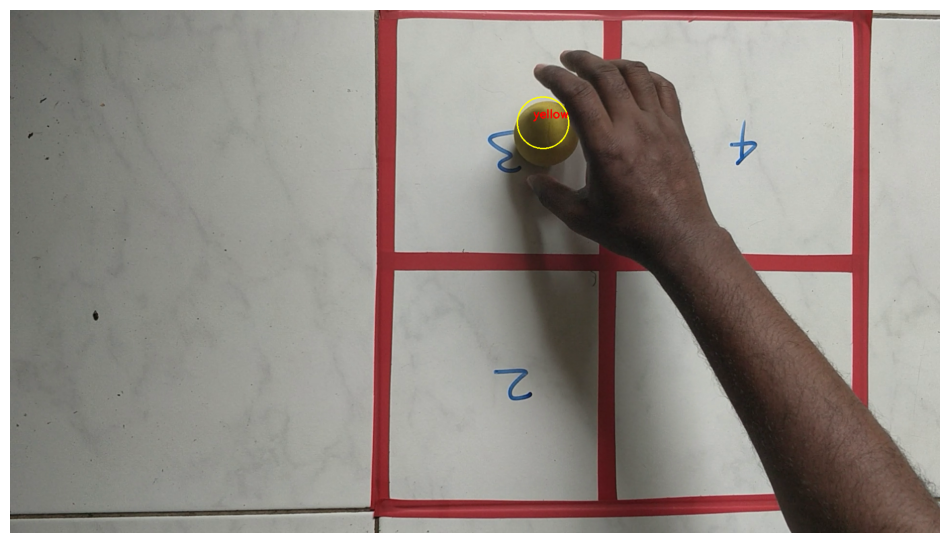

82 yellow Entry 3


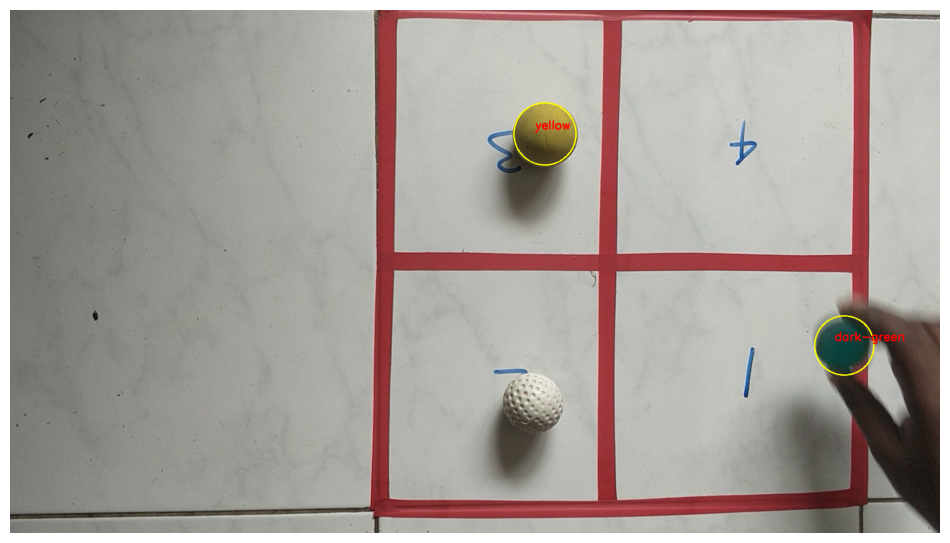

277 dark-green Entry 1


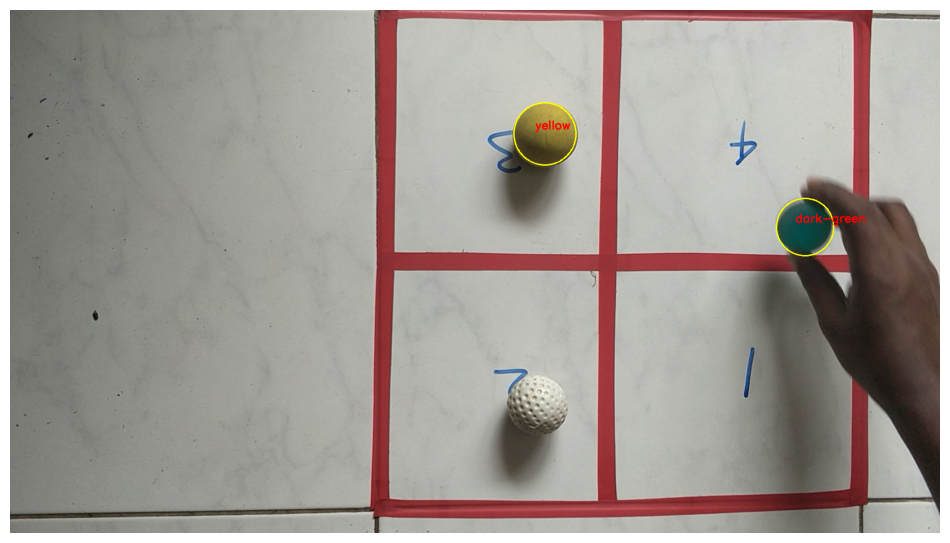

280 dark-green Entry 4 Exit 1


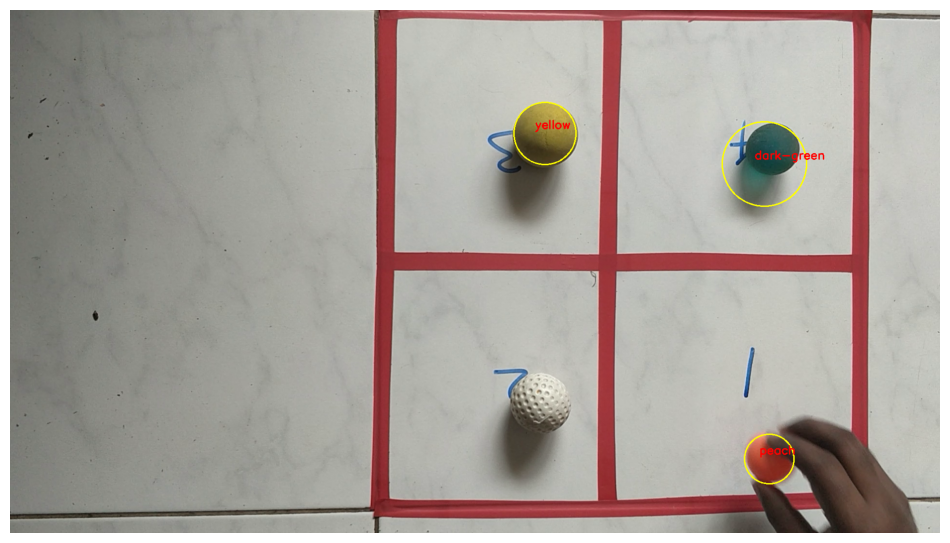

365 peach Entry 1


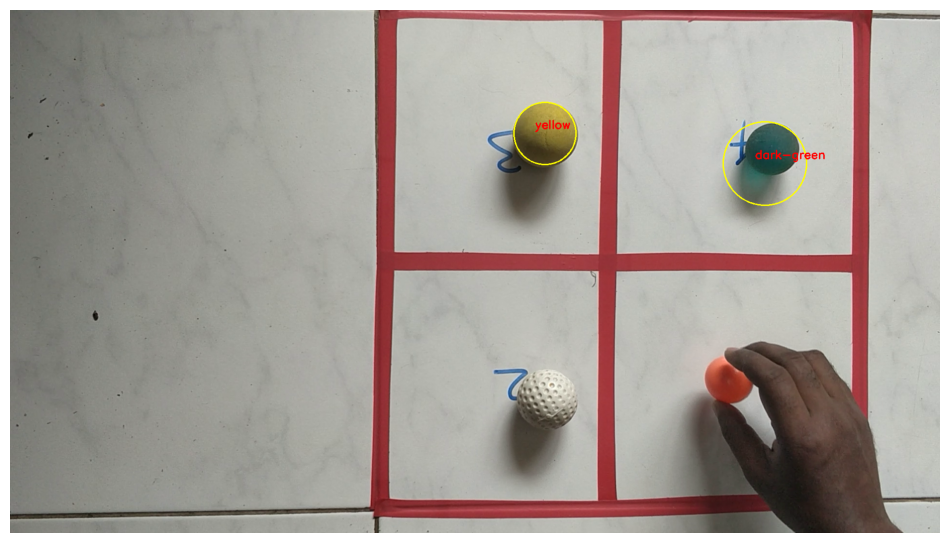

371 peach Exit 1


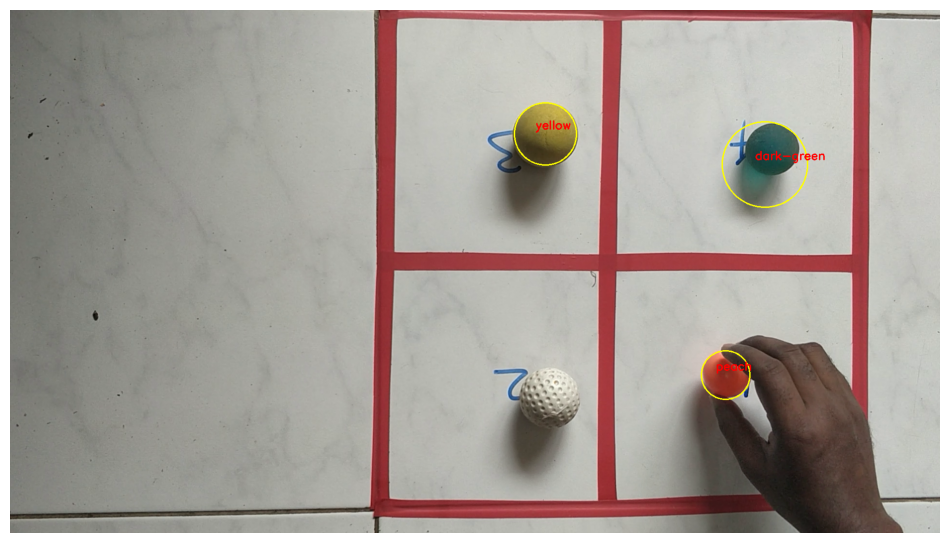

373 peach Entry 1


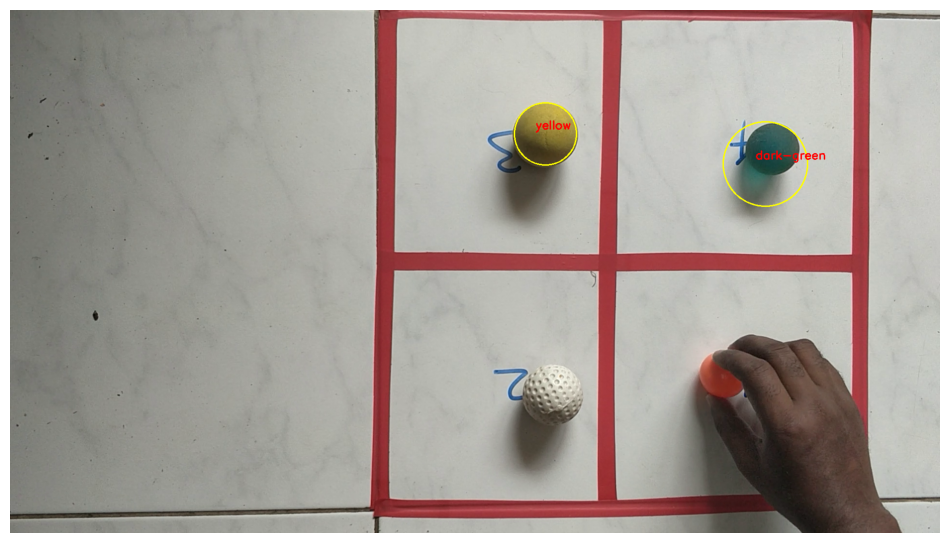

376 peach Exit 1


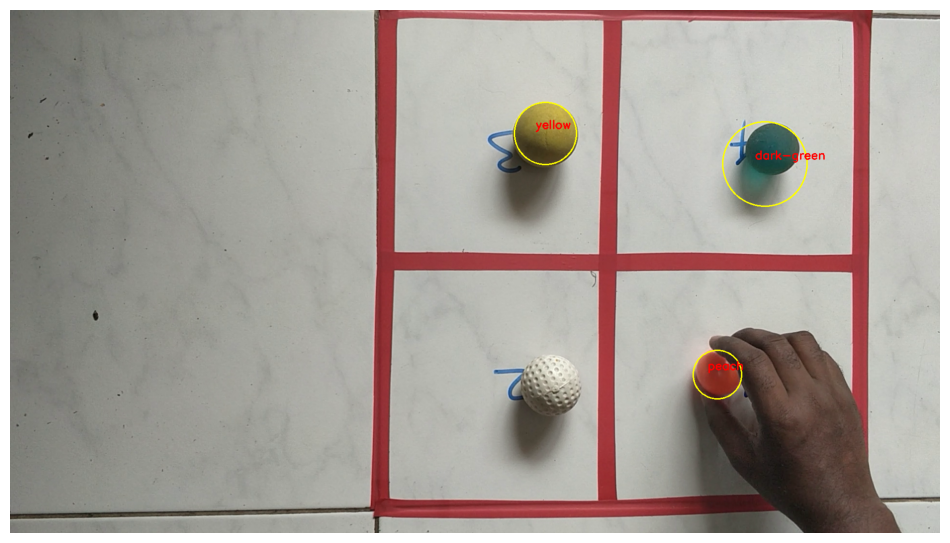

386 peach Entry 1
{'time': 2.73, 'color': 'yellow', 'zone': 3, 'Event': 'Entry'}
{'time': 9.23, 'color': 'dark-green', 'zone': 1, 'Event': 'Entry'}
{'time': 9.33, 'color': 'dark-green', 'zone': 1, 'Event': 'Exit'}
{'time': 9.33, 'color': 'dark-green', 'zone': 4, 'Event': 'Entry'}
{'time': 12.17, 'color': 'peach', 'zone': 1, 'Event': 'Entry'}
{'time': 12.37, 'color': 'peach', 'zone': 1, 'Event': 'Exit'}
{'time': 12.43, 'color': 'peach', 'zone': 1, 'Event': 'Entry'}
{'time': 12.53, 'color': 'peach', 'zone': 1, 'Event': 'Exit'}
{'time': 12.87, 'color': 'peach', 'zone': 1, 'Event': 'Entry'}


In [68]:
generator = sv.get_video_frames_generator(source_path='/content/AI Assignment video.mp4')
iterator = iter(generator)
frame_no=1
prev_loc=[0,0,0]
log=[]
while frame_no < 500:
  frame = next(iterator)
  t=round(frame_no/fps,2)
  loc=[0,0,0]
  detect(frame,loc)
  for i in range(3):
    color=color_code(i)
    if prev_loc[i]==0 and loc[i]!=0: #entry
      log.append({"time": t,"color": color, "zone": loc[i], "Event": "Entry"})
      sv.plot_image(frame,(12,12))
      print(frame_no,color,"Entry",loc[i])
    elif prev_loc[i]!=0 and loc[i]==0: #exit
      log.append({"time": t,"color": color, "zone": prev_loc[i], "Event": "Exit"})
      sv.plot_image(frame,(12,12))
      print(frame_no,color,"Exit",prev_loc[i])
    elif prev_loc[i]!=0 and loc[i]!=0 and prev_loc[i]!=loc[i]:
      log.append({"time": t,"color": color, "zone": prev_loc[i], "Event": "Exit"})
      log.append({"time": t,"color": color, "zone": loc[i], "Event": "Entry"})
      sv.plot_image(frame,(12,12))
      print(frame_no,color,"Entry",loc[i],"Exit",prev_loc[i])
  frame_no+=1
  prev_loc=loc
for entry in log:
  print(entry)

## Formal functions to do detection

In [69]:
def process_frame(frame: np.ndarray, _) -> np.ndarray: #process a single frame and return the edited frame
  global frame_no
  global prev_loc
  global log
  global fps
  global Event
  t=round(frame_no/fps,2) #time in seconds
  loc=[0,0,0]

  #detect the balls
  detect(frame,loc)

  #detect events
  for i in range(3):
    color=color_code(i)
    #Entry
    if prev_loc[i]==0 and loc[i]!=0:
      log.append({"time": t,"color": color, "zone": loc[i], "Event": "Entry"})
      Event=str(t)+": Entry of "+ color+" ball at zone "+str(loc[i])

    #Exit
    elif prev_loc[i]!=0 and loc[i]==0: #exit
      log.append({"time": t,"color": color, "zone": prev_loc[i], "Event": "Exit"})
      Event=str(t)+": Exit of "+ color+" ball at zone "+str(prev_loc[i])

    #Change zone
    elif prev_loc[i]!=0 and loc[i]!=0 and prev_loc[i]!=loc[i]: #change zone
      log.append({"time": t,"color": color, "zone": prev_loc[i], "Event": "Exit"})
      log.append({"time": t,"color": color, "zone": loc[i], "Event": "Entry"})
      Event=str(t)+": Entry of "+ color+" ball at zone "+str(loc[i])+" from zone "+str(prev_loc[i])

  #print event on the frame
  cv2.putText(frame, Event, (100, 540),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (39, 100, 100), 2)
  frame_no+=1
  prev_loc=loc
  return frame

In [70]:
def ball_tracking(video_path: str, output_path: str): #Main function to detection
  global frame_no
  global prev_loc
  global log
  global fps
  global Event
  frame_no=1
  log=[]
  prev_loc=[0,0,0]
  Event = "None"
  video_info=sv.VideoInfo.from_video_path(video_path='/content/AI Assignment video.mp4')
  print(video_info)
  fps=video_info.fps
  sv.process_video(source_path=video_path,
                  target_path=output_path,
                  callback=process_frame)
  f=open("/content/log.txt","w")
  for entry in log:
    f.write(str(entry)+"\n")
  f.close()

In [71]:
video_path='/content/AI Assignment video.mp4'
output_path='/content/processed_video.mp4'
ball_tracking(video_path,output_path)

VideoInfo(width=1920, height=1080, fps=30, total_frames=3183)


## Conclusion

The task assigned was to create a computer vision program to track the movement of balls of different colors across various quadrants in a provided video. The program was expected to record events of each ball entering and exiting each numbered quadrant in the format: ***Time, Quadrant Number, Ball Colour, Type (Entry or Exit)***. The processed video would display ball tracking with color, overlay text indicating "Entry" or "Exit" along with a timestamp, and generate a text file recording these events.

**Achievements**
* **Ball Detection:** Successfully detected all balls except the golf ball.
* **Tracking and Event Recording:** Implemented the functionality to track the movement of balls and record events in the specified format.
* **Processed Video:** Created a processed video with overlays indicating ball movement events and timestamps.

**Challenges and Limitations**
* **Golf Ball Detection:** The golf ball posed a significant challenge due to its white color, which blended with the background. Efforts to create a color mask for detection were unsuccessful due to the lack of contrast and the ball's lack of smooth edges, complicating edge detection methods.

* **Peach Ball Detection in Second Quadrant:** The peach-colored ball was inconsistently detected in the second quadrant, likely due to variations in lighting conditions or inaccuracies in defining the color range for peach. Further refinement of the color range or additional preprocessing steps might be needed to enhance detection accuracy.

* **Occlusion Handling:** The program faced difficulties when the ball was temporarily obscured by a hand. When the ball became visible again, it was erroneously recorded as a new entry event, despite not having moved from its place. This issue arises from the inability of the current model to account for temporary occlusions without reinitializing the detection.

**Conclusion**

While the program achieved the primary objectives of detecting and tracking multiple colored balls and recording their movements across quadrants, certain limitations affected the accuracy and reliability of the results. In particular, the detection of the white golf ball and handling of occlusions require further refinement. Despite these challenges, the core functionalities were implemented successfully, and the program produced meaningful outputs as specified.